In [39]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,Bidirectional,LSTM,Embedding, Masking
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


##### instanciating a new model and loading the saved weights 

In [40]:
def instanciateTopicModel():
    from keras.models import Model
    from keras.layers import Input, Embedding, Masking, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, Dropout

    vector_size = 16
    max_length = 64  # Adjust this according to your data
    V = 10000  # Vocabulary size, adjust this according to your data
    K = len(uniqueTags)  # Number of classes, adjust this according to your problem

    i = Input(shape=(max_length,))
    x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
    x = Masking()(x)  # Masking layer to handle variable length sequences
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.8)(x)  # Dropout layer with 50% dropout rate
    x = GlobalMaxPooling1D()(x)  # Use global pooling to reduce to (batch_size, 64)
    x = Dense(64, activation='relu')(x)  # Added a Dense layer for further processing
    x = Dropout(0.5)(x)  # Dropout layer after Dense layer
    x = Dense(K, activation='softmax')(x)  # Output layer with K units

    NewModel = Model(i, x)

    NewModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    NewModel.load_weights("../models/topicClassification.keras")
    NewModel.summary()



In [41]:
def loading_data(data_path):
    
    data = pd.read_json(data_path)
    
    data.dropna(inplace=True)
    print("Number of rows : ",data.shape[0]," and the number of columns : ",data.shape[1])
    
    return data

In [42]:
data = loading_data("../dataset/topicClassificationDataset.json")

Number of rows :  16506  and the number of columns :  2


### Statistics About the corpus 

                                                sentence          theme  \
0      0.000123, which corresponds to a distance of 7...        science   
1      000webhost is a free web hosting service, oper...     technology   
2      0010x0010 is a dutch-born audiovisual artist, ...            art   
3      0-0-1-3 is an alcohol abuse prevention program...         health   
4      0.01 is the debut studio album of h3llb3nt, re...            art   
...                                                  ...            ...   
16501  2007 production was 40 million pounds of molyb...        economy   
16502  2007 ptt bangkok open was a tennis tournament ...         sports   
16503  2007 romanian figure skating championships wer...         sports   
16504  2007 royal mail industrial disputes were a ser...       politics   
16505  2007's 1,000 pies, herndon employed the musica...  entertainment   

       sentence_length  
0                   12  
1                   10  
2                   11  

C:\Users\INFOKOM\AppData\Local\Temp\ipykernel_12928\1579440206.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.index, y=theme_counts.values, palette='viridis')


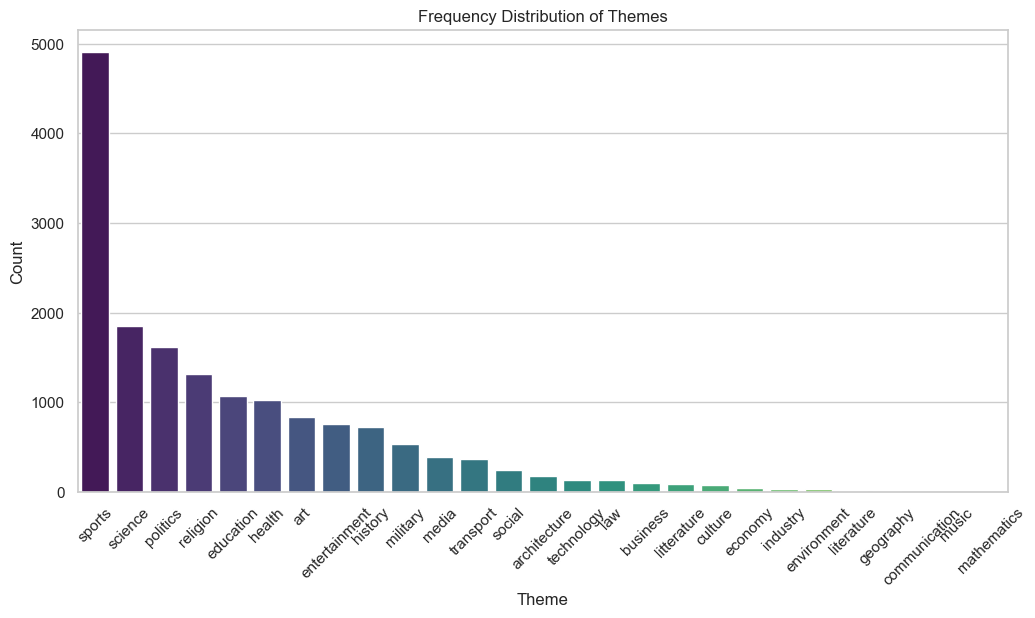

C:\Users\INFOKOM\AppData\Local\Temp\ipykernel_12928\1579440206.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_percentages.index, y=theme_percentages.values, palette='viridis')


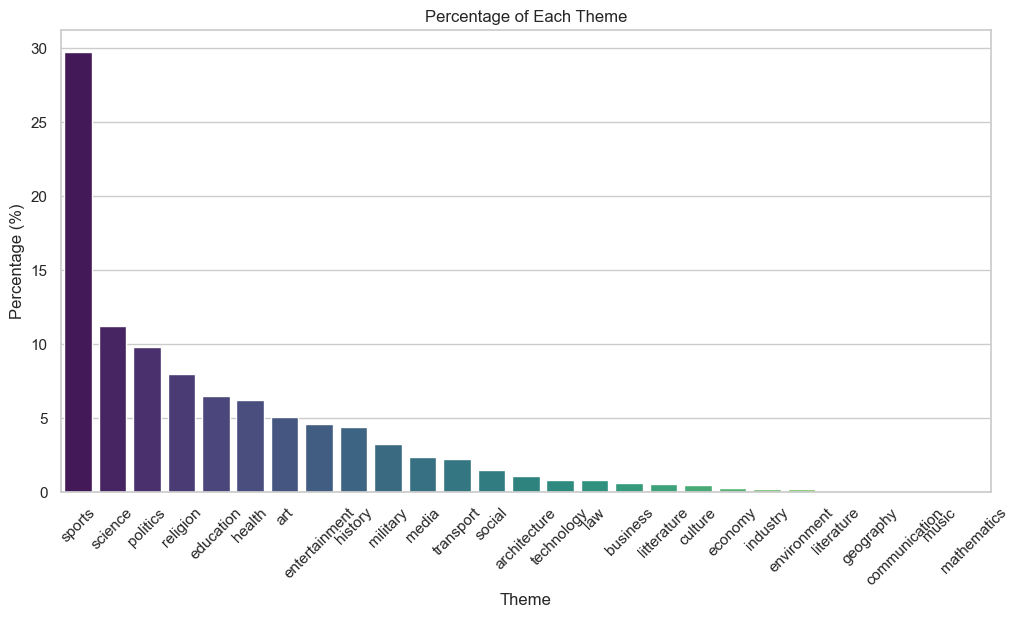

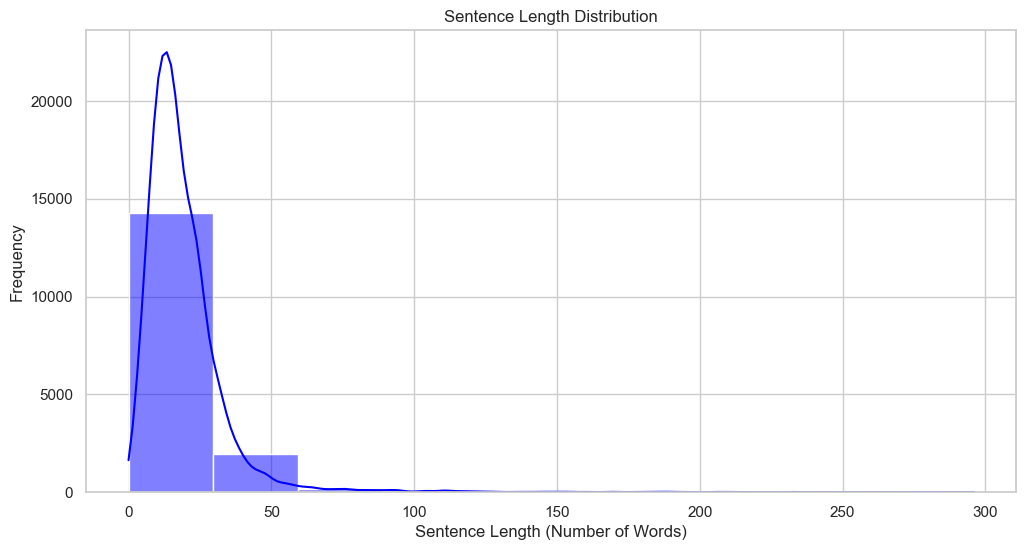

C:\Users\INFOKOM\AppData\Local\Temp\ipykernel_12928\1579440206.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_length_by_theme.index, y=avg_length_by_theme.values, palette='viridis')


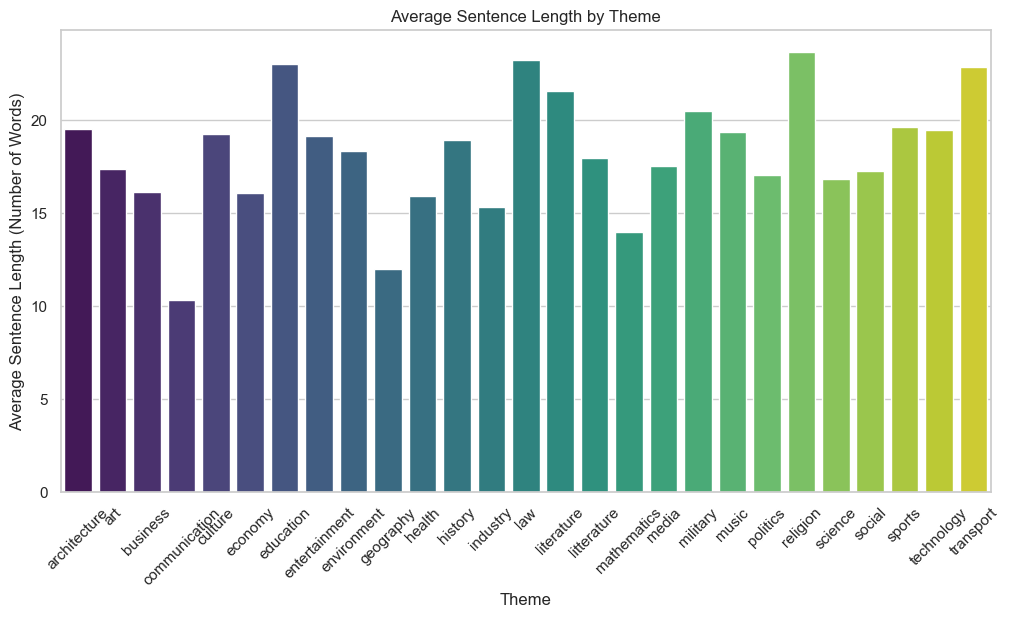

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = data

# Calculate sentence length
df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
print(df)

# Frequency Distribution of Themes
theme_counts = df['theme'].value_counts()

# Percentage of Each Theme
theme_percentages = df['theme'].value_counts(normalize=True) * 100

# Average Sentence Length by Theme
avg_length_by_theme = df.groupby('theme')['sentence_length'].mean()

# Plotting

# Frequency Distribution of Themes
plt.figure(figsize=(12, 6))
sns.barplot(x=theme_counts.index, y=theme_counts.values, palette='viridis')
plt.title('Frequency Distribution of Themes')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Percentage of Each Theme
plt.figure(figsize=(12, 6))
sns.barplot(x=theme_percentages.index, y=theme_percentages.values, palette='viridis')
plt.title('Percentage of Each Theme')
plt.xlabel('Theme')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()

# Sentence Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['sentence_length'], bins=10, kde=True, color='blue')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Average Sentence Length by Theme
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_length_by_theme.index, y=avg_length_by_theme.values, palette='viridis')
plt.title('Average Sentence Length by Theme')
plt.xlabel('Theme')
plt.ylabel('Average Sentence Length (Number of Words)')
plt.xticks(rotation=45)
plt.show()


In [44]:
import torch
from transformers import BertTokenizer

def tokenize_with_bert(sentences, max_length=64):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
            max_length=max_length,        # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,   # Construct attention masks.
            return_tensors='pt',          # Return pytorch tensors.
            truncation=True
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Example usage:
train_inputs_bert, train_attention_masks = tokenize_with_bert(data['sentence'], max_length=64)


C:\Users\INFOKOM\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
bertEmbeddings=[]
for embedding in train_inputs_bert:
    bertEmbeddings.append(embedding)

In [46]:
data['sentence']=bertEmbeddings

In [47]:
df_final = data[['sentence','theme']]

In [48]:
uniqueTags=list(set(data['theme']))

In [49]:
tag_to_index = {tag: index for index, tag in enumerate(uniqueTags)}
df_final['theme'] = df_final['theme'].map(tag_to_index)

C:\Users\INFOKOM\AppData\Local\Temp\ipykernel_12928\3739621643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['theme'] = df_final['theme'].map(tag_to_index)


In [50]:
df_train,df_test=train_test_split(df_final,test_size=0.2,random_state=42 )

In [51]:
train_targets = list(df_train.theme.values)
test_targets = list(df_test.theme.values)

train_inputs =(df_train['sentence'])
test_inputs = (df_test['sentence'])

In [52]:
train_tags = train_targets
test_tags = test_targets 

print("Unique  tags in train set: ",train_tags)
print("Unique  tags in test set: ",test_tags)

Unique  tags in train set:  [7, 12, 26, 7, 9, 21, 11, 9, 20, 7, 25, 7, 3, 7, 2, 7, 7, 26, 20, 10, 12, 21, 7, 11, 25, 11, 7, 9, 7, 10, 3, 20, 0, 9, 19, 10, 10, 20, 20, 7, 2, 4, 7, 20, 7, 11, 14, 7, 7, 17, 10, 7, 21, 7, 14, 4, 7, 21, 7, 25, 7, 11, 25, 7, 10, 26, 25, 9, 7, 7, 11, 26, 10, 10, 11, 7, 25, 7, 7, 9, 7, 4, 20, 4, 20, 12, 3, 17, 7, 9, 12, 11, 25, 7, 19, 20, 11, 7, 7, 11, 17, 7, 16, 7, 7, 4, 9, 11, 9, 25, 7, 11, 7, 10, 7, 25, 0, 21, 11, 16, 9, 20, 21, 16, 7, 12, 11, 7, 19, 7, 7, 9, 25, 9, 13, 21, 10, 7, 7, 7, 4, 14, 11, 11, 7, 7, 26, 9, 12, 7, 11, 7, 11, 25, 17, 21, 7, 20, 12, 16, 7, 11, 26, 7, 11, 16, 20, 2, 7, 21, 4, 20, 5, 7, 9, 20, 12, 23, 7, 7, 11, 11, 7, 9, 21, 9, 17, 12, 25, 20, 7, 7, 11, 21, 11, 7, 20, 7, 9, 7, 7, 17, 11, 20, 2, 25, 17, 21, 7, 12, 21, 7, 10, 16, 7, 26, 2, 12, 12, 21, 4, 11, 13, 25, 25, 26, 7, 11, 7, 10, 20, 17, 12, 20, 25, 10, 10, 7, 11, 7, 9, 9, 11, 15, 26, 7, 21, 7, 4, 20, 18, 26, 11, 7, 25, 5, 7, 10, 19, 4, 19, 25, 11, 12, 25, 7, 11, 7, 7, 7, 7, 7, 17,

In [53]:

train_tgt_int = train_targets
test_tgt_int =test_targets

In [54]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = np.array(train_tgt_int)
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final =np.array(test_tgt_int)
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (13204, 64)
Shape of test inputs:  (3302, 64)
Shape of train targets:  (13204,)
Shape of test targets:  (3302,)


In [55]:
from tensorflow.keras.models import Sequential

In [62]:
from keras.models import Model
from keras.layers import Input, Embedding, Masking, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, Dropout

vector_size = 16
max_length = 64  # Adjust this according to your data
V = 10000  # Vocabulary size, adjust this according to your data
K = len(uniqueTags)  # Number of classes, adjust this according to your problem

i = Input(shape=(max_length,))
x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
x = Masking()(x)  # Masking layer to handle variable length sequences
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.8)(x)  # Dropout layer with 50% dropout rate
x = GlobalMaxPooling1D()(x)  # Use global pooling to reduce to (batch_size, 64)
x = Dense(64, activation='relu')(x)  # Added a Dense layer for further processing
x = Dropout(0.5)(x)  # Dropout layer after Dense layer
x = Dense(K, activation='softmax')(x)  # Output layer with K units

model = Model(i, x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


C:\Users\INFOKOM\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\layer.py:857: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64, 16)    │    160,016 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 64, 16)    │          0 │ embedding_3[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 64, 16)    │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 64)        │          0 │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 64, 64)    │     12,544 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 64, 128)   │     66,048 │ bidirectional_9[… │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 64, 256)   │    263,168 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64, 256)   │          0 │ bidirectional_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ dropout_6[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     16,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 27)        │      1,755 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 519,979 (1.98 MB)

 Trainable params: 519,979 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [64]:
 # Define callbacks
checkpoint = ModelCheckpoint("/kaggle/working/model_checkpoint.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    train_inputs_final,
    train_targets_final,
    epochs=30,
    validation_data=(test_inputs_final, test_targets_final),
    callbacks=[checkpoint],
)

Epoch 1/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3178 - loss: 2.4166
Epoch 1: val_loss improved from inf to 2.32909, saving model to /kaggle/working/model_checkpoint.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 90s 184ms/step - accuracy: 0.3179 - loss: 2.4159 - val_accuracy: 0.4864 - val_loss: 2.3291
Epoch 2/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5355 - loss: 1.4696
Epoch 2: val_loss improved from 2.32909 to 1.82862, saving model to /kaggle/working/model_checkpoint.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 78s 188ms/step - accuracy: 0.5356 - loss: 1.4694 - val_accuracy: 0.6208 - val_loss: 1.8286
Epoch 3/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6520 - loss: 1.1061
Epoch 3: val_loss improved from 1.82862 to 1.78047, saving model to /kaggle/working/model_checkpoint.keras
413/413 ━━━━━━━━━━━━━━━━━━━━ 84s 203ms/step - accuracy: 0.6520 - loss: 1.1060 - val_accuracy: 0.6336 - val_loss: 1.7805
Epoch 4/30
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - acc

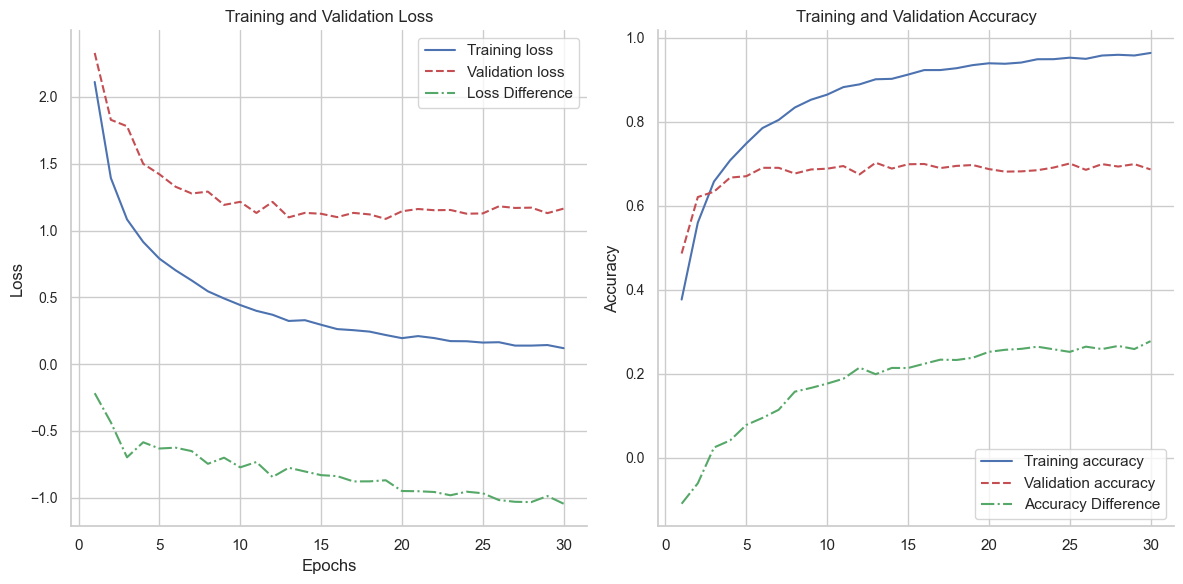

In [65]:
sns.set(style="whitegrid")

# Get training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Calculate differences
loss_diff = [train_loss[i] - val_loss[i] for i in range(len(train_loss))]
acc_diff = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]

# Plot training and validation loss in subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.plot(epochs, loss_diff, 'g-.', label='Loss Difference')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation accuracy')
plt.plot(epochs, acc_diff, 'g-.', label='Accuracy Difference')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(fontsize=10)

plt.tight_layout()

# Show plot
plt.show()


##### Saving the model 

In [66]:
import keras
savedModels=keras.saving.save_model(model,"../models/topicClassification.keras")

##### instanciating a new model and loading the saved weights 


In [61]:
def instanciateTopicModel():
    from keras.models import Model
    from keras.layers import Input, Embedding, Masking, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, Dropout

    vector_size = 16
    max_length = 64  # Adjust this according to your data
    V = 10000  # Vocabulary size, adjust this according to your data
    K = len(uniqueTags)  # Number of classes, adjust this according to your problem

    i = Input(shape=(max_length,))
    x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
    x = Masking()(x)  # Masking layer to handle variable length sequences
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.8)(x)  # Dropout layer with 50% dropout rate
    x = GlobalMaxPooling1D()(x)  # Use global pooling to reduce to (batch_size, 64)
    x = Dense(64, activation='relu')(x)  # Added a Dense layer for further processing
    x = Dropout(0.5)(x)  # Dropout layer after Dense layer
    x = Dense(K, activation='softmax')(x)  # Output layer with K units

    NewModel = Model(i, x)

    NewModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    NewModel.load_weights("../models/topicClassification.keras")
    NewModel.summary()

